Import nessesory library

In [2]:
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

#download chest x-ray image dataset

In [3]:
!git clone https://github.com/RishitToteja/Chext-X-ray-Images-Data-Set.git

Cloning into 'Chext-X-ray-Images-Data-Set'...
remote: Enumerating objects: 2319, done.
remote: Total 2319 (delta 0), reused 0 (delta 0), pack-reused 2319
Receiving objects: 100% (2319/2319), 1.31 GiB | 37.15 MiB/s, done.
Updating files: 100% (2296/2296), done.


In [4]:
import os
main_dir="Chext-X-ray-Images-Data-Set/DataSet/Data"

#Setting training and testing directory.
train_dir=os.path.join(main_dir,'train')
test_dir=os.path.join(main_dir,'test')

#setting covid and normal images directory for train and test
train_covid_dir=os.path.join(train_dir,'COVID19')
train_normal_dir=os.path.join(train_dir,'NORMAL')

test_covid_dir=os.path.join(test_dir,'COVID19')
test_normal_dir=os.path.join(test_dir,'NORMAL')

In [5]:
train_covid_names=os.listdir(train_covid_dir)
train_normal_names=os.listdir(train_normal_dir)

test_covid_names=os.listdir(test_covid_dir)
test_normal_names=os.listdir(test_normal_dir)

print("Total No of Images in dataset : {}".format((len(train_covid_names)+len(train_normal_names)+len(test_covid_names)+len(test_normal_names))))

Total No of Images in dataset : 2295


Data Visualization : visualize 8 images from traing covid and train normal.

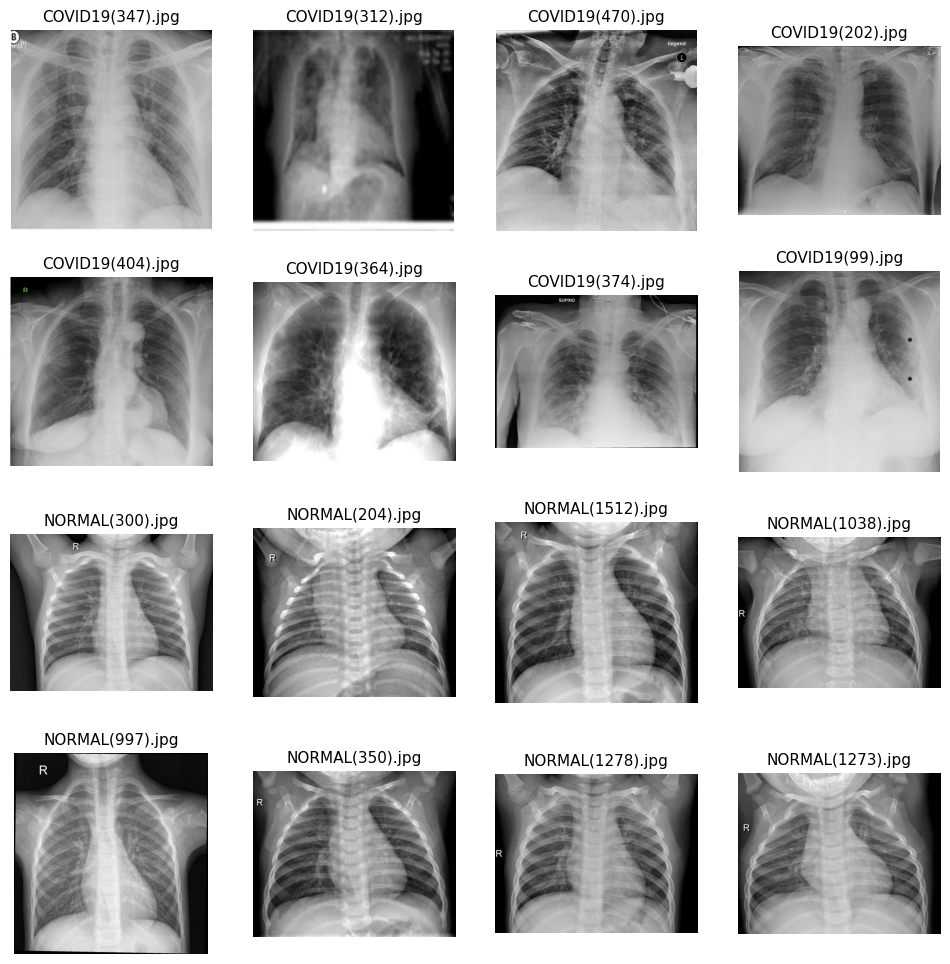

In [6]:
import matplotlib.image as mpimg
rows=4
cols=4

fig=plt.gcf()
fig.set_size_inches(12,12)

covid_images=[os.path.join(train_covid_dir,filename) for filename in train_covid_names[0:8]]
normal_images=[os.path.join(train_normal_dir,filename) for filename in train_normal_names[0:8]]

merge_images=covid_images+normal_images

for i,img_path in enumerate(merge_images):
  title=img_path.split('/')[-1]
  plot=plt.subplot(rows,cols,i+1)
  plt.axis('off')
  img=mpimg.imread(img_path)
  plot.set_title(title,size=11)
  plt.imshow(img,cmap='gray')

Data Augumentation :

In [7]:
#create training,testing and validation generator.
train_idg=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                       validation_split=0.2,
                                                       zoom_range=0.2,
                                                       horizontal_flip=True
                                                       )
test_idg=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_idg=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen=train_idg.flow_from_directory(directory=train_dir,
                                        target_size=(150,150),
                                        subset='training',
                                        batch_size=32,
                                        class_mode='binary')

valid_gen=train_idg.flow_from_directory(directory=train_dir,
                                        target_size=(150,150),
                                        subset='validation',
                                        batch_size=32,
                                        class_mode='binary')


test_gen=train_idg.flow_from_directory(directory=test_dir,
                                        target_size=(150,150),
                                        batch_size=32,
                                        class_mode='binary')

Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [8]:
print("Class Tabels : ,",train_gen.class_indices)
print("Dimenshion of the images : ",train_gen.image_shape)

Class Tabels : , {'COVID19': 0, 'NORMAL': 1}
Dimenshion of the images :  (150, 150, 3)


Model Building :

In [9]:
model=keras.models.Sequential()

#1 Chunk
model.add(keras.layers.Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu',input_shape=train_gen.image_shape))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.5))
#2 Chunk
model.add(keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.5))

#Flatten layer
model.add(keras.layers.Flatten())
#Hidden layer
model.add(keras.layers.Dense(units=256,activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
#prediction layer
model.add(keras.layers.Dense(units=1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

In [10]:
#define early stopping to avoid over training
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

In [11]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

Model Training :

In [12]:
history=model.fit(train_gen,epochs=40,validation_data=valid_gen,callbacks=[early_stopping])

Epoch 1/40
46/46 [==============================] - 78s 1s/step - loss: 1.3299 - accuracy: 0.6915 - val_loss: 0.4174 - val_accuracy: 0.8978
Epoch 2/40
46/46 [==============================] - 57s 1s/step - loss: 0.2495 - accuracy: 0.8979 - val_loss: 0.2162 - val_accuracy: 0.9337
Epoch 3/40
46/46 [==============================] - 76s 2s/step - loss: 0.1693 - accuracy: 0.9434 - val_loss: 0.1504 - val_accuracy: 0.9530
Epoch 4/40
46/46 [==============================] - 65s 1s/step - loss: 0.1522 - accuracy: 0.9427 - val_loss: 0.1566 - val_accuracy: 0.9558
Epoch 5/40
46/46 [==============================] - 63s 1s/step - loss: 0.1088 - accuracy: 0.9669 - val_loss: 0.1309 - val_accuracy: 0.9558
Epoch 6/40
46/46 [==============================] - 50s 1s/step - loss: 0.1445 - accuracy: 0.9510 - val_loss: 0.1296 - val_accuracy: 0.9613
Epoch 7/40
46/46 [==============================] - 45s 973ms/step - loss: 0.1244 - accuracy: 0.9607 - val_loss: 0.1546 - val_accuracy: 0.9337
Epoch 8/40
46/46 

In [13]:
#print key of history object
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Model Evaluation

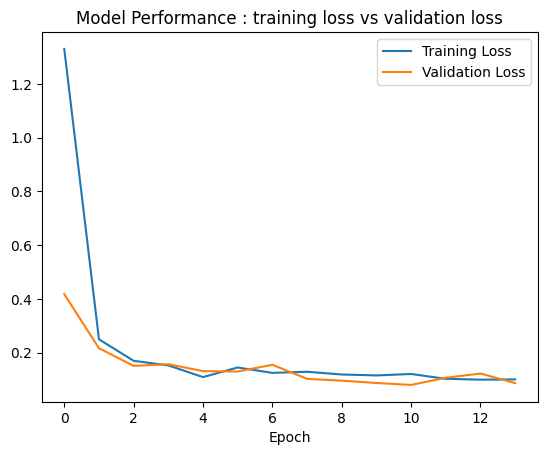

In [16]:
#plot training and validation loss
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')

plt.legend()
plt.title('Model Performance : training loss vs validation loss')
plt.xlabel('Epoch')
plt.show()

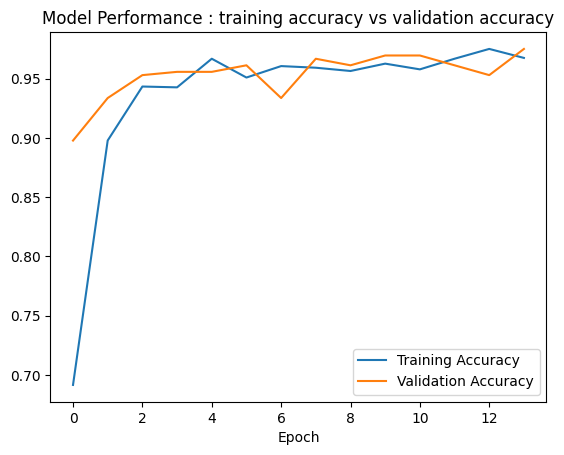

In [17]:
#plot training and validation loss
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')

plt.legend()
plt.title('Model Performance : training accuracy vs validation accuracy')
plt.xlabel('Epoch')
plt.show()

In [15]:
#Getting Test accuracy and test loss
test_loss, test_acc=model.evaluate(test_gen)
print('Test Loss : ',test_loss)
print('Test Accuracy : ',test_acc)

16/16 [==============================] - 12s 740ms/step - loss: 0.1203 - accuracy: 0.9711
Test Loss :  0.1203402578830719
Test Accuracy :  0.9710744023323059


Make Prediction on NEW DATA

In [33]:
#combine 10 covid and normal images and take any 1 random image for testing
covid_images=os.listdir("Chext-X-ray-Images-Data-Set/DataSet/Data/test/COVID19")[:5]
normal_images=os.listdir("Chext-X-ray-Images-Data-Set/DataSet/Data/test/NORMAL")[:5]
test_images=covid_images+normal_images
filename=np.random.choice(test_images)

normal_path='Chext-X-ray-Images-Data-Set/DataSet/Data/test/NORMAL'
covid_path="Chext-X-ray-Images-Data-Set/DataSet/Data/test/COVID19"

def getImage(filename):
  if 'NORMAL' in filename:
    img=keras.preprocessing.image.load_img(os.path.join(normal_path,filename),target_size=(150,150))
    img=keras.preprocessing.image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    return img
  elif 'COVID' in filename:
    img=keras.preprocessing.image.load_img(os.path.join(covid_path,filename),target_size=(150,150))
    img=keras.preprocessing.image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    return img

input_image=getImage(filename)
prediction=model.predict(input_image)

if prediction == 0:
  print('Patient is covid positive')
elif prediction == 1:
  print('Patient is covid Negative')

1/1 [==============================] - 0s 18ms/step
Patient is covid positive


Save Trained CNN model to integration and use

In [34]:
model.save("covid_prediction_model.keras")